Определяем вспомогательные функции

In [11]:
import pydotplus
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def plot(data, labels, column_1_number, column_2_number, title):
    X = np.array(data)[:, column_1_number]
    Y = np.array(data)[:, column_2_number]
    cs = [labels[i] for i in range(len(labels))]
    plt.scatter(X, Y, c=cs, s=15)
    plt.xlim(0)
    plt.ylim(0)
    plt.title(title)
    plt.show()

def load_dataset(file, data_columns, target_column):
    x = np.genfromtxt(file, delimiter=',', dtype=float, skip_header=True, usecols=data_columns)
    y = np.genfromtxt(file, delimiter=',', dtype=float, skip_header=True, usecols=target_column)
    return x, y

def decision_tree_save(clf, iris, file, colorize=False):
    dot_data = tree.export_graphviz(clf, out_file=None,
                                    feature_names=iris['feature_names'],
                                    class_names=iris['target_names'],
                                    filled=True,
                                    rounded=True,
                                    special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    nodes = graph.get_node_list()

    if colorize:
        for node in nodes:
            if node.get_label():
                class_name = node.get_label().split('class = ')[1].split('>')[0]
                if class_name == 'High frequency':
                    node.set_fillcolor('#FF0000')
                elif class_name == 'Middle frequency':
                    node.set_fillcolor('#FFA200')
                elif class_name == 'Low frequency':
                    node.set_fillcolor('#058900')

    graph.write_pdf(file)

def draw_roc_curve(classes, y_test, y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves')
    plt.legend(loc="lower right")
    plt.show()

def draw_cross_val_score(clf, X, Y, cv, scalled=False):
    t = cross_val_score(clf, X, Y, cv=cv)
    plt.plot(range(cv), t, 'k--')
    if scalled:
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
    plt.title('Cross-validation result')
    plt.show()


def calc_score(y_test, y_predicted):
    y_test = np.array(map(np.argmax, y_test))
    y_predicted = np.array(map(np.argmax, y_predicted))

    counter = 0
    scores = 0
    for y in y_predicted:
        if y == y_test[counter]:
            scores += 1
        counter += 1

    return float(scores) / float(counter)

Подключаем необохдимые фичи scikit learn (в т. ч. используемый классификатор)

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

Конфигурируем, описываем data-set

In [13]:
dataset_file = '../data/cars.csv'
target_column = 8
iris = {
    'feature_names': ['Car', 'Price', 'Experience', 'Car age', 'Gender', 'Ownership type', 'Vehicle class', 'Annual mileage'],
    'target_names': ['High frequency', 'Middle frequency', 'Low frequency']
}

Загружаем data-set

In [14]:
X, Y = load_dataset(dataset_file, tuple(range(len(iris['feature_names']))), (target_column,))
Y_binarized = label_binarize(Y, classes=range(len(iris['target_names'])))
n_classes = Y_binarized.shape[1]

Разделяем выборку на train и test в пропорции 10% / 90%

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, Y_binarized, test_size=0.9)

Получаем инстанс decision tree классификатора

In [16]:
clf = DecisionTreeClassifier()

Обучаем алгоритм по train выборке

In [17]:
clf_fit = clf.fit(X_train, y_train)

Предсказываем значения train выборки

In [18]:
y_predicted_train = clf.predict(X_train)

Считаем и выводим score по y фактическому и y предсказанному для train выборки

In [20]:
score = calc_score(y_train, y_predicted_train)
print(score)

1.0


Предсказываем значения test выборки

In [21]:
y_predicted = clf.predict(X_test)

Считаем и выводим score по y фактическому и y предсказанному для test выборки

In [22]:
score = calc_score(y_test, y_predicted)
print(score)

0.92


Визуализируем дерево решений, которое сформировал классификатор, и сохраняем в pdf-файл

In [23]:
decision_tree_save(clf, iris, "decision_tree.pdf")

Предсказываем target-значения по выборке, опираясь на обученный ранее алгоритм (делаем выбор по дереву решений)

In [24]:
y_score = clf.predict(X_test)

Строим ROC-кривые для оценки качества классификации (по всем классам)

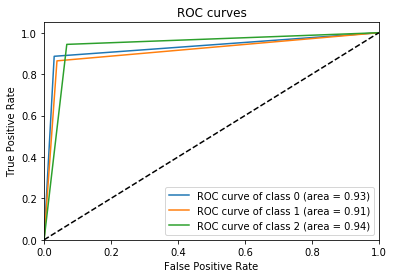

In [25]:
draw_roc_curve(n_classes, y_test, y_score)

Делаем кросс-валидацию с указанным кол-вом разбиений и показываем на графике средние ошибки

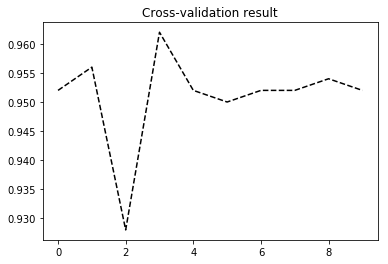

In [26]:
draw_cross_val_score(clf, X, Y_binarized, cv=10)